# Wine Quality "Warm up" Challenge


## Introduction

In the following presentation we are outlining our key findings about the statistical properties of the dataset given, before we discuss the chosen model and justify its performance. In the presentation we provide plots and code where it is feasable, but we try to convey our message mostly with short consise statements and theoretical information. A "scratchbook" consisting of the used code are supplied to support our claims, and give the reader an oppertunity to examine the code himself.

The dataset given consist of various types of wine and has 1599 observations of red wine and 4898 observations of white wine. For each type we have the wine quality (scored between 0 and 10) and eleven chemical attributes.

In [0]:
#libraries 
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from imblearn.over_sampling import RandomOverSampler

#Model libraries
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import log_loss
from sklearn.metrics import f1_score
from sklearn.metrics import precision_recall_fscore_support as score

## Data preparation 

TODO:
* Talk about overfitting/underfitting
* Do not talk about every iteration, but say that we worked hard and show our results
* Maybe only remove outliers from trainingset, and not from testset




After examining the datasets for the white- and red wine, we found no differences between the columns of the two tables. We therefore decided to combine two datasets into a single one in order to reduce complexity. It is also convenient with a single model that can determine the overall quality of a wine, regardless of its color. The wines are described using the following attributes:


* <b>Fixed acidity</b> - The most acids involved with the wine taste such as tartaric, malic, citric, and succinic.
* <b>Volatile acidity</b> - The acids that are steam distilled acids present in wine.
* <b>Citric acid</b> - The acid that is found in citrus fruits, especially lemons and limes. It’s what gives to wine the tart and sour taste.
* <b>Residual sugar</b> - The amount of sugar that remains in a wine after fermentation completes. 
* <b>Chlorides</b> - The amount of salt in the wine 
* <b>Free sulfur dioxide (SO2) </b> - The amount of SO2 that is not bound to other molecules, and is used to exert an antioxidant/preservative action.
* <b>Total sulfur dioxide (SO2) </b> - The total amount of free and bound forms of S02;
* <b>Density</b> - The winemaking measurement that defined as the mass, or weight, per volume of material.
* <b>pH</b> - The measure of the degree of relative acidity versus the relative alkalinity of any liquid, on a scale of 0 to 14, with 7 being neutral.
* <b>Sulphates</b> - The food preservative playing an important role in preventing oxidization and maintaining a wine's freshness
* <b>Alcohol</b> - The percentage of alcohol in the wine measured in % volume

* <b> Quality</b> - The output variable rated from "0" to "10" 



In [0]:
winequality_red = pd.read_csv('winequality-red.csv', delimiter=';')
winequality_white = pd.read_csv('winequality-white.csv', delimiter=';') 
winequality = pd.concat([winequality_red, winequality_white], axis=0).astype(float)

To improve our models chances of producing useful predictions, we convert our quality feature to a binary value, and thereby converting the problem to a classification problem. The quality feature are given from the dataset as a value from 1-10, but in reality a wine is good only if its quality are above some (rather individual) threshold. For the sake of argument we set this threshold to 7, but it could easily be changed in the future. This means that a wine is marked as "good" if its quality is 7 or above, and "bad" if its quality are below 7. We denote "good" as 1 and "bad" as 0.

In [0]:
# Convert all the target quality numbers to binary.
quality_threshold = 7

winequality.loc[winequality['quality'] < quality_threshold, 'quality'] = 0
winequality.loc[winequality['quality'] >= quality_threshold, 'quality'] = 1

The head of the dataset are plotted to give the reader an understanding of the data at hand.

In [0]:
winequality.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,0.0
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,0.0
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,0.0
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,0.0
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,0.0


<b>Feature selection</b>

Since the quality feature are the feature we are trying to predict from new wines, it is regarded as the target variable. It is interesting to study how much a wines attribute corrolates with the quality of the wine. The table below shows the detailed pearson correlation between each attribute and the quality feature. The pearson correlation are a number between -1 and 1 that indicates the extent to which two variables are linearly corrolated. 




In [0]:
winequality_correlations = winequality.corr()['quality'].drop('quality')
print(winequality_correlations)

fixed acidity          -0.049447
volatile acidity       -0.151714
citric acid             0.054444
residual sugar         -0.063992
chlorides              -0.161781
free sulfur dioxide     0.014767
total sulfur dioxide   -0.051226
density                -0.275441
pH                      0.028149
sulphates               0.033971
alcohol                 0.390486
Name: quality, dtype: float64


The correlation table indicates that "alcohol" and "density" have the highest correlation with the quality, while "free sulfur dioxide", "total sulfur dioxide", "pH" have low correlation with the quality. Because of this, we can probably remove these last features from the analysis all together. Although it might sound counter intuitive to remove information, we do not want our model to care about insignificant things that draw the attention from the features that are actually corolated with the target we are trying to explain. 

Further, we can not assume that our model are able to handle outliers. Outliers are datapoints that lie too far away from the normal to be of any value, and are as such removed from the dataset. They can occur because of measuring errors, or simply because they are extreme cases. They are so rare that we are not interested in predicting they properly.  We do not want our model to try to learn these values when they differ too much from the other points, as that deteriorates our model. The outlier are defined as points that lie more than 3 standard deivations away from the mean, and are removed with the code below.

In [0]:
winequality = winequality[(np.abs(stats.zscore(winequality))<3).all(axis=1)]

<b>Train test split</b>
The dataset are split into a trainingset and testset with the code below. Because it proved to perform the best, the  trainingset contains 70% of the datapoints and the testset containes the remaining 30% of the datapoints.

In [0]:
winequality_X = winequality.drop('quality', axis=1)
winequality_y = winequality['quality']

wq_train_X, wq_test_X, wq_train_y, wq_test_y = train_test_split(winequality_X, winequality_y, test_size=0.3, random_state=42)


It can be observed from the dataset head that the features have vastly different scales on the numbers. For example are the numbers for the chlorides feature much smaller than the numbers for the total sulfur dioxide feature. Depending on the model used, this might not be an issue, but for others it can have a huge impact on performance. Because one of the models used in the model selection step are dependent on the scaling of the feature values, the features are scaled with a MinMaxScaler. This however, has to only be done for the features, and *not* for the target.

In [0]:
normalizer = MinMaxScaler()
normalizer = normalizer.fit(wq_train_X)
wq_train_X = normalizer.transform(wq_train_X)
wq_test_X = normalizer.transform(wq_test_X)

## Data Visualization


After preparing our data, we need to examine how it is distributed to be able to make a clever decision about what type of model to use.



It is observed that most densities of the variables conditioned on the quality of the wine:
1.   Approximately follow a Gaussian distribution. 
2.   The two conditional densities follow near-identical distributions with each other apart from the 'density' variable and the 'alcohol' variable.

An implication of the first is that we can standardize the data prior to building predictive models.

We better visualize the 'alcohol' variable below.

Text(0, 0.5, 'Distribution')

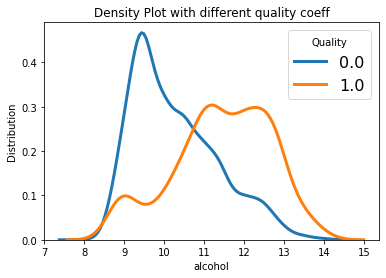

In [0]:
qualitys = np.unique(winequality.quality.values)

for q in qualitys:
    subset = winequality[winequality['quality'] == q]
    
    # Draw the density plot
    sns.distplot(subset['alcohol'], hist = False, kde = True,
                 kde_kws = {'linewidth': 3},
                 label = q)
    
# Plot formatting
plt.legend(prop={'size': 16}, title = 'Quality')
plt.title('Density Plot with different quality coeff')
plt.xlabel('alcohol')
plt.ylabel('Distribution')

## Model selection 

After having prepared and visualized the data, we are ready to start selecting a model for our analysis. To start, we created a simple baseline model to have a performance measure when we evaluate the other models performance. Following that, we tried with a few common algorithms that are likely to work well with this data, before selecting the one with the best classifiaction accuracy on the testingset and lowest log loss. In the end the hyperparameters were tuned and the performance was discussed.

Because about 80% of the datapoints in the dataset are "bad" wines, a reasonable rule of thumb for this spesific case should be an accuracy of about 80%. This would imply guessing "bad" on all wines, and thereby getting a correct guess for all the bad wines.


<b>Baseline model (linear regression)</b>

The simples model are arguably the linear regression. It often failes to model complex statistical corrolations in a satisfying way, but are simple and easy to train. It is therefore chosen as the baseline model. 

In [0]:
baseline_model = LinearRegression()
baseline_model.fit(wq_train_X, wq_train_y)
baseline_wq_pred_y = pd.DataFrame(np.round(baseline_model.predict(wq_test_X)))
baseline_acc = accuracy_score(wq_test_y, baseline_wq_pred_y)
print('Baseline testing accuracy:', baseline_acc)
baseline_log_loss = log_loss(baseline_wq_pred_y, wq_test_y)
print('Baseline log loss: ', baseline_log_loss)

Baseline testing accuracy: 0.8180809761508597
Baseline log loss:  6.283389539868494


<b>Naive Byaes</b>

The 'Naive' assumption in Naive Bayes classifier is that p(x_i | y, x_1, ... , x_i-1, x_i+1, ..., x_n) = p(x_i | y).
But let x_i = pH. The assumption obviously doesn't hold (in our case) given that the set of other variables comprises of measurements like acidity. So, given that our data violates a significant assumption of the derivation of Naive Bayes, we don't expect this model to perform te best. And as expected, the accuracy is lower than the other models.

In [0]:
gnb_clf = GaussianNB()
gnb_clf.fit(wq_train_X, wq_train_y)
gnb_wq_pred_y = gnb_clf.predict(wq_test_X)
gnb_acc = accuracy_score(wq_test_y, gnb_wq_pred_y)
print('GaussianNB testing accuracy:', gnb_acc)
gnb_log_loss = log_loss(gnb_wq_pred_y, wq_test_y)
print('GauusianNB log loss: ', gnb_log_loss)

GaussianNB testing accuracy: 0.7609539656128674
GauusianNB log loss:  8.25642405203607


<b>SVC</b> 

In [0]:
svm_clf = svm.SVC()
svm_clf.fit(wq_train_X, wq_train_y)

#linear_SVC
svm_wq_pred_y = svm_clf.predict(wq_test_X)
svm_acc = accuracy_score(wq_test_y, svm_wq_pred_y)
print('SVC testing accuracy:', svm_acc)
svm_log_loss = log_loss(svm_wq_pred_y, wq_test_y)
print('SVM log loss: ', svm_log_loss)

SVC testing accuracy: 0.8291735995562951
SVM log loss:  5.900250152503794


**KNN**

In [0]:
knn_clf = KNeighborsClassifier(n_neighbors=2)
knn_clf.fit(wq_train_X, wq_train_y)
knn_wq_pred_y = knn_clf.predict(wq_test_X)
knn_acc = accuracy_score(wq_test_y, knn_wq_pred_y)
print('KNN testing accuracy:', knn_acc)
knn_log_loss = log_loss(knn_wq_pred_y, wq_test_y)
print('KNN log loss: ', knn_log_loss)

KNN testing accuracy: 0.8546866333887965
KNN log loss:  5.019039007724316


<b>Linear Discriminant Analysis</b> 

In [0]:
lda_clf = LinearDiscriminantAnalysis()
lda_clf.fit(wq_train_X, wq_train_y)
lda_wq_pred_y = lda_clf.predict(wq_test_X)
lda_acc = accuracy_score(wq_test_y, lda_wq_pred_y)
print('LDA testing accuracy:', lda_acc)
lda_log_loss = log_loss(lda_wq_pred_y, wq_test_y)
print('LDA log loss: ', lda_log_loss)

LDA testing accuracy: 0.8130892956184138
LDA log loss:  6.455778338347132


<b>Random Forest</b> 

There are many ways to construct a random forest — these differences in the method of construction are described as tuning parameters. One of the most important tuning parameters in building a random forest is the number of trees to construct. 

We will try adjusting the following set of hyperparameters:
-  *n_estimators* is the parameter specifying the number of trees inRandomForestClassifier 
- *max_depth* is the parameter specifying the maximum depth of each tree.


In [0]:
RF_clf = RandomForestClassifier(n_estimators = 100, max_depth=30)
RF_clf.fit(wq_train_X, wq_train_y)
RF_wq_pred_y = RF_clf.predict(wq_test_X)
print("Random forest testing accuracy :", accuracy_score(RF_wq_pred_y, wq_test_y))

RF_log_loss = log_loss(RF_wq_pred_y, wq_test_y)
print('Random forest log loss: ', RF_log_loss)

Random forest testing accuracy : 0.8785357737104825
Random forest log loss:  4.1953011436764145


**Neural network**

**Hyper parameter tuning**



The model that performed the best on the testset was the random forest classifier. It needs to be further refined by tuning the hyperparameters so we can achieve an even better accuracy.


In [0]:
parameters = { 
              'n_estimators': [50, 100, 150, 200, 250],
              'max_depth': [5, 10, 15, 20, 25, 30, 35, 40, 45]
             }
RF_clf_tuned = RandomForestClassifier()
RF_clf_tuned = GridSearchCV(RF_clf_tuned, param_grid=parameters, scoring='neg_log_loss',cv=10)
RF_clf_tuned.fit(wq_train_X, wq_train_y)
print("The best parameters are: ", RF_clf_tuned.best_params_)

RF_tuned_wq_pred_y_train = RF_clf_tuned.predict(wq_train_X)
print("Random forest training accuracy :", accuracy_score(RF_tuned_wq_pred_y_train, wq_train_y))

RF_tuned_wq_pred_y_test = RF_clf_tuned.predict(wq_test_X)
print("Random forest testing accuracy :", accuracy_score(RF_tuned_wq_pred_y_test, wq_test_y))

RF_tuned_log_loss = log_loss(RF_tuned_wq_pred_y_test, wq_test_y)
print('Random forest log loss: ', RF_log_loss)

## Performance evaluation

The random forest model with tuned hyperparameters achieves an accuracy on the testset of 0.88, which are better than the baseline of 0.82, and the random guess of 0.8. An accuracy on the trainingset of X.XX indicates that we do not have a problem with overfitting, and the model should generalize well to unseen data. Give the nature of ensamble models, and the high complexity of a random tree with XXX layers, it would have been likely for the model to overfit.

## Data Imbalance, the F-Measure & Recall Issue

It is important to aknowledge that accuracy by itself can be meaningless in Machine Learning. 

That is usually the case in classification problems when the dataset is highly imbalanced. 

Let's visualize the quality distribution of the wine data.



Text(0.5, 1.0, 'Distribution of low quality vs high quality wine')

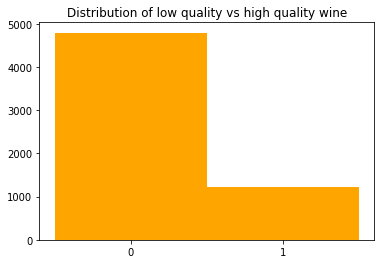

In [0]:
ls = [int(f) for f in winequality.quality.values]
plt.hist(ls, bins = np.arange(3)-0.5, align = 'mid', color = 'orange')
plt.xticks([0,1])
plt.title('Distribution of low quality vs high quality wine')

We can see that the ratio of low quality to high quality wine is around 4:1. This means that even if we always classify a wine type as low quality, we will be correct roughly 80% of the time.

It's in situations like these that accuracy loses meaning. We use F-measure & Recall in this situation, which are useful metrics for imbalanced datasets. They basically enable us to see how well we are doing on classifying different classes.

We check both these metrics for SVM.

In [0]:
precision, recallSVM, fscoreSVM, support = score(wq_test_y, svm_wq_pred_y)

print('SVM:')
print('recall for low quality wine: {} ; recall for high quality wine {}'.format(np.round(recallSVM[0], 2), np.round(recallSVM[1], 2)))
print('f-score for low quality wine: {} ; fscore for high quality wine {}'.format(np.round(fscoreSVM[0], 2), np.round(fscoreSVM[1], 2)))

SVM:
recall for low quality wine: 0.97 ; recall for high quality wine 0.26
f-score for low quality wine: 0.9 ; fscore for high quality wine 0.37


A possible solution to the dataset imbalance is data oversampling. That is, during training, we sample data from the minority class with repetition. Thus removing the bias created by the dominating quantity of one class. 

We now choose that the cardinality of the high quality training dataset be 60% of the cardinality of the low quality dataset. 

In [0]:
oversample = RandomOverSampler(ratio = 0.6)
os_wq_train_X, os_wq_train_y = oversample.fit_sample(wq_train_X, wq_train_y)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Let's visualize the new class distribution of the training data. 

Text(0.5, 1.0, 'Distribution of low quality vs high quality wine')

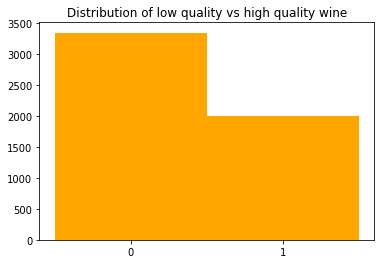

In [0]:
ls = [int(f) for f in os_wq_train_y]
plt.hist(ls, bins = np.arange(3)-0.5, align = 'mid', color = 'orange')
plt.xticks([0,1])
plt.title('Distribution of low quality vs high quality wine')

We re-train/test the algorithm (SVM) above using the "new" training data.

<b>SVM via Over Samling</b>

In [0]:
svm_clf_os = svm.SVC()
svm_clf_os.fit(os_wq_train_X, os_wq_train_y)
#linear_SVC
svm_wq_pred_y_os = svm_clf_os.predict(wq_test_X)
svm_log_loss = log_loss(svm_wq_pred_y, wq_test_y)
svm_acc = accuracy_score(wq_test_y, svm_wq_pred_y)
precision, recallOSVM, fscoreOSVM, support = score(wq_test_y, svm_wq_pred_y_os)

print('SVC testing accuracy:', svm_acc)
print('SVM log loss: ', svm_log_loss)
print('')
print('SVM recall for low quality wine: {} ; recall for high quality wine {}'.format(np.round(recallOSVM[0], 2), np.round(recallOSVM[1], 2)))
print('SVM f-score for low quality wine: {} ; fscore for high quality wine {}'.format(np.round(fscoreOSVM[0], 2), np.round(fscoreOSVM[1], 2)))

SVC testing accuracy: 0.8291735995562951
SVM log loss:  5.900250152503794

SVM recall for low quality wine: 0.87 ; recall for high quality wine 0.66
SVM f-score for low quality wine: 0.89 ; fscore for high quality wine 0.59


<b>Random Forest via Over Sampling</b>

<b>Visualization of Recall & F-Score after Over Sampling

We can already tell that the Recall and F-Score for the high quality wine classification have significantly improved for SVM 

We now visualize the changes in Recall and F-Score with the results we obtained.

In [0]:
recall_data_high = [0.16857142857142857, 0.4, 0.4, 0.28285714285714286, 0.5142857142857142]
recall_data_low = [0.9745354439091535, 0.9642119752236752, 0.9642119752236752, 0.9408121128699243, 0.9662766689607708]
recall_os_low = [0.836200963523744, 0.8651066758430833, 0.9318651066758431, 0.8348245010323468, 0.9552649690295939]
recall_os_high = [0.5885714285714285, 0.66, 0.5714285714285714, 0.5885714285714285, 0.5828571428571429]
fscore_data_high = [0.2645739910313901, 0.5166051660516605, 0.5166051660516605, 0.3700934579439253, 0.6217616580310881]
fscore_data_low = [0.8962025316455696, 0.9144908616187989, 0.9144908616187989, 0.8902637577336373, 0.9276511397423192]
fscore_os_low = [0.864153627311522, 0.8886532343584306, 0.9157930334798782, 0.8633451957295374, 0.9293605624372279]
fscpre_os_high = [0.5188916876574307, 0.5945945945945946, 0.6163328197226502, 0.5175879396984924, 0.6591276252019386]

In [0]:
barWidth = 0.25
r1 = np.arange(5)
r2 = [x + barWidth for x in r1]

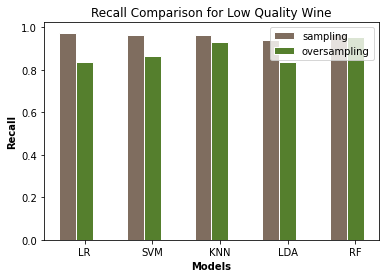

In [0]:
plt.bar(r1, recall_data_low, color='#7f6d5f', width=barWidth, edgecolor='white', label='sampling')
plt.bar(r2, recall_os_low, color='#557f2d', width=barWidth, edgecolor='white', label='oversampling')

plt.title('Recall Comparison for Low Quality Wine')
plt.xlabel('Models', fontweight='bold')
plt.ylabel('Recall', fontweight='bold')
plt.xticks([r + barWidth for r in range(5)], ['LR', 'SVM', 'KNN', 'LDA', 'RF'])
plt.legend()
plt.show()


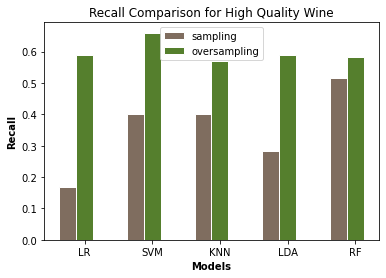

In [0]:
plt.bar(r1, recall_data_high, color='#7f6d5f', width=barWidth, edgecolor='white', label='sampling')
plt.bar(r2, recall_os_high, color='#557f2d', width=barWidth, edgecolor='white', label='oversampling')

plt.title('Recall Comparison for High Quality Wine')
plt.xlabel('Models', fontweight='bold')
plt.ylabel('Recall', fontweight='bold')
plt.xticks([r + barWidth for r in range(5)], ['LR', 'SVM', 'KNN', 'LDA', 'RF'])
plt.legend()
plt.show()


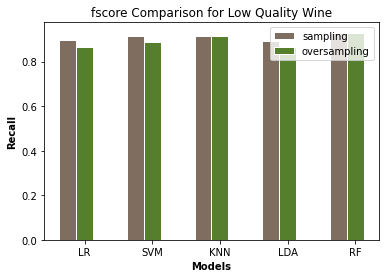

In [0]:
plt.bar(r1, fscore_data_low, color='#7f6d5f', width=barWidth, edgecolor='white', label='sampling')
plt.bar(r2, fscore_os_low, color='#557f2d', width=barWidth, edgecolor='white', label='oversampling')

plt.title('fscore Comparison for Low Quality Wine')
plt.xlabel('Models', fontweight='bold')
plt.ylabel('Recall', fontweight='bold')
plt.xticks([r + barWidth for r in range(5)], ['LR', 'SVM', 'KNN', 'LDA', 'RF'])
plt.legend()
plt.show()

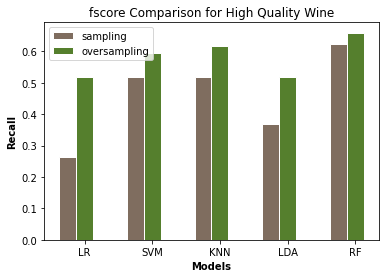

In [0]:
plt.bar(r1, fscore_data_high, color='#7f6d5f', width=barWidth, edgecolor='white', label='sampling')
plt.bar(r2, fscore_os_high, color='#557f2d', width=barWidth, edgecolor='white', label='oversampling')

plt.title('fscore Comparison for High Quality Wine')
plt.xlabel('Models', fontweight='bold')
plt.ylabel('Recall', fontweight='bold')
plt.xticks([r + barWidth for r in range(5)], ['LR', 'SVM', 'KNN', 'LDA', 'RF'])
plt.legend()
plt.show()

As noticed, the performance on the Low Quality wine has only slightly gone down. Whereas the performance for the High Quality Wine has gone up by a lot. We evaluated the situation this way: having a model that is correct because one class dominates is not useful. We desire to recognize the other class. 

So we agree that oversampling helped our predictions significantly since now our model is much more capable of identifying a high quality wine. There is something that the model "sacrificed" to increase its capability. But the sacrifice was very minimal since its ability to recognize low quality wine decreased very little.

## Conclusion 

Based on the analysis made we come to the conclusion that not all input features are essential and affect the data. 

Without oversampling we have achieved above 80% accuracy in 4/5 models selected but noticed that metrics that give evaluation specifically in different classes have shown inconsistency. 

We performed oversampling to have a more even performance on the different classes and thus generalize better.

